In [ ]:
## This cell will install the required dependencies in the current environment
!pip install numpy cython
!cd ../../ && pip install -r requirements.txt


# TT recipes: Sensitivity Analysis Examples

This notebook shows how to use the __sensitivity analysis__ methods from __TT recipes__. These examples use functions from the built-in library of well-known test functions included in the submodule _models_. Some of these examples have been used for related scientific publications:

  - [1] _Sobol Tensor Trains for Global Sensitivity Analysis._
    Rafael Ballester-Ripoll, Enrique G. Paredes, Renato Pajarola
    [[arXiv](https://arxiv.org/abs/1712.00233)]

  - [2] _Tensor Approximation of Advanced Metrics for Sensitivity Analysis._
    Rafael Ballester-Ripoll, Enrique G. Paredes, Renato Pajarola
    [[arXiv](https://arxiv.org/abs/1712.01633)]

In [1]:
import pprint
import random
import numpy as np
from IPython.display import HTML, display
%matplotlib inline

# The most important "import" statement!
import ttrecipes as tr

Let's set some general settings for the examples in this tutorial:

  - __bins__ will be used as the default number of samples per axis
  - __max_order__ indicates the maximum order of the indices reported (all possible orders are always computed, this only affects the report tables)
  - __verbose__ sets the _verbose_ mode to __True__ or __False__
  - __seed__ is the random seed that will be used for Python and NumPy's random generators


In [2]:
# Number of samples per axis
bins = 100

# Maximum order of the shown sensitivity indices 
max_order = 2

# Verbose mode (True/False)
verbose = True

# Set a seed value (e.g. 9999) if you want to get
# always the same results 
seed = None  # 9999
if seed is not None:
    random.seed(seed)
    np.random.seed(seed)

## Piston function

We will use as a first example a function modeling the circular motion of a piston within a cylinder with a chain of nonlinear functions:

\begin{equation}
f(\vec{x}) = 2 \pi \sqrt{\frac{M}{k + S^2 \frac{P_0 V_0}{T_0} \frac{T_a}{V^2}}}
\end{equation}

with:

\begin{equation}
\begin{gathered}
V = \frac{S}{2k} \left(\sqrt{A^2 + 4k \frac{P_0 V_0}{T_0} T_a} - A\right) \\
A = P_0 S + 19.62 M - \frac{k V_0}{S}
\end{gathered}
\end{equation}

More details about the function can be found at the [Virtual Library of Simulation Experiments](https://www.sfu.ca/~ssurjano/piston.html) from [Simon Fraser University](https://www.sfu.ca).

The first step is to get the function object and the axis definitions from the library of test models included in TT recipes:

In [3]:
# Get example function and axes definitions from 'ttrecipes.models'
f_piston, axes_piston = tr.models.get_piston()
pprint.pprint(axes_piston)

[{'domain': (30, 60), 'name': 'M'},
 {'domain': (0.005, 0.02), 'name': 'S'},
 {'domain': (0.002, 0.01), 'name': 'V_0'},
 {'domain': (1000, 5000), 'name': 'k'},
 {'domain': (90000, 110000), 'name': 'P_0'},
 {'domain': (290, 296), 'name': 'T_a'},
 {'domain': (340, 360), 'name': 'T_0'}]


The exact meaning of each one of the parameters is explained in the documentation of the function __tr.sensitivity_analysis.var_metrics()__:

In [4]:
help(tr.sensitivity_analysis.var_metrics)

Help on function var_metrics in module ttrecipes.sensitivity_analysis:

var_metrics(fun, axes, default_bins=100, effective_threshold=0.95, dist_fraction=5e-05, fun_mode='array', eps=1e-05, verbose=False, cross_kwargs=None, max_order=2, show=False)
    Variance-based sensitivity analysis.
    
    User-friendly wrapper that conducts a general variance-based sensitivity
    analysis on an N-dimensional black-box function according to the given
    marginal distributions.
    
    Args:
        fun (callable): Callable object representing the N-dimensional function.
        axes (iterable): A list of axis definitions. Each axis is a `dict` with
            the name of the axis variable, its domain and its distribution function.
    
            axis: dict(name, domain, dist)
                name (str): Variable name. Defaults to x_{i} (i = axis index).
    
                domain (tuple or np.ndarray): Domain definition. Defaults to tuple(None, None)
    
                    tuple -> boun

And now let's compute and show the actual indices. With __TT recipes__ this is as simple as calling the __tr.sensitivity_analysis.var_metrics()__ function with the function object and the axis definitions. In this example we set the parameter __print_results__ to __True__ to get the results tables printed.

All the other parameters are optional and control different settings, as the default number of samples per axes when it is not specifically set for every axis, the target relative error of the approximation, and more specific settings for the TT cross approximation algorithm. Check the documentation of the function in the previous cell.

In [5]:
# Compute sensitivity indices and print result tables
print("+ Computing tensor approximations of variance-based sensitivity metrics...")
metrics = tr.sensitivity_analysis.var_metrics(
    f_piston, axes_piston, default_bins=bins, verbose=verbose, eps=1e-5,
    cross_kwargs=dict(), max_order=max_order, show=True)

+ Computing tensor approximations of variance-based sensitivity metrics...

-> Building surrogate model
Cross-approximating a 7D function with target error 1e-05...
=multifuncrs= sweep 1{2}, max_dy: 1.654e+03, erank: 5.23723
=multifuncrs= sweep 2{1}, max_dy: 3.658e-03, erank: 8.29802
=multifuncrs= sweep 2{2}, max_dy: 3.658e-03, erank: 10.0854
=multifuncrs= sweep 3{1}, max_dy: 3.819e-05, erank: 11.1739
=multifuncrs= sweep 3{2}, max_dy: 3.819e-05, erank: 11.1739
=multifuncrs= sweep 4{1}, max_dy: 6.389e-06, erank: 11.3578
Function evaluations: 593400
The resulting tensor has ranks [1, 9, 19, 20, 10, 8, 7, 1] and 90300 elements

-> Computing sensitivity metrics
=multifuncrs= sweep 1{2}, max_dy: 1.160e+00, erank: 7.71825
=multifuncrs= sweep 2{1}, max_dy: 2.560e-06, erank: 7.71825

-> Exporting results

		 ** SENSITIVITY INDICES **
Variable       Sobol     Total    Shapley    Banzhaf-Coleman
----------  --------  --------  ---------  -----------------
M           0.039123  0.050564   0.04467

By default only indices up to second order are collected and printed. If we are interested in higher order interactions, we can collect more indices by simply running again the computation code with a different *max_order* parameter. Actually, since all the Sobol indices have been already computed and encoded in a Sobol Tensor Train, we can also call __tr.sensitivity_analysis.tabulate_metrics()__ (or __tr.sensitivity_analysis.collect_sobol()__) with the previously computed *metrics* object and the desired *max_order* value.

Note that we can generate and export tables with different styles by using __tabulate_metrics()__ with the powerful formatting options from the [tabulate](https://bitbucket.org/astanin/python-tabulate) package. For example, we can generate HTML tables in a notebook environment or save individual tables as **TSV/CSV** files. All the examples in the *examples/sensitivity_analysis/piston.py* folder have a command line argument to export the results.

In [6]:
# Collect sensitivity indices of a different order from the 
# already computed Sobol Tensor Train
output = tr.sensitivity_analysis.tabulate_metrics(
    metrics, max_order=4, show_titles=False, output_mode='string', tablefmt='html')
display(HTML(output))

# # Export results as CSV tables 
# tables = tr.sensitivity_analysis.tabulate_metrics(
#     metrics, max_order=2, tablefmt='tsv', output_mode='dict', show_titles=False)
# for key, value in tables.items():
#     with open("piston_" + key + ".csv", 'w') as f:
#         f.write(value)


#### Querying Sobol indices

The function **tr.sensitivity_analysis.query_sobol()** can answer a range of sensitivity queries. It takes a Sobol Tensor Train as an input and produces a) a tuple and b) the variance attained by that tuple. It works on Sobol, Total/Closed Sobol, and Superset indices. See some examples below:

In [7]:
print("** Model variables: {} **\n".format(metrics['variables']))
print("Highest order-2 total index:",
      tr.sensitivity_analysis.query_sobol(metrics, max_order=2,
                                          index_type='total'))

** Model variables: ['M', 'S', 'V_0', 'k', 'P_0', 'T_a', 'T_0'] **

Highest order-2 total index: (['S', 'V_0'], 0.93783378259588235)


In [8]:
print("Lowest order-1 closed index:",
      tr.sensitivity_analysis.query_sobol(metrics, min_order=1,
                                          index_type='closed', mode='lowest'))

Lowest order-1 closed index: (['T_a'], 3.3623571379370887e-06)


In [9]:
print("Highest order-2 superset index, other than ['T_a'} (or [5]):",
      tr.sensitivity_analysis.query_sobol(metrics, exclude=['T_a'], max_order=2,
                                          index_type='superset', mode='highest'))

Highest order-2 superset index, other than ['T_a'} (or [5]): (['S'], 0.59921879652525611)


In [10]:
print("Single variable that interacts the most with ['S'] (or [1]):",
      tr.sensitivity_analysis.query_sobol(metrics, include=['S'],
                                          min_order=2, max_order=2,
                                          index_type='superset', mode='highest'))

Single variable that interacts the most with ['S'] (or [1]): (['S', 'k'], 0.032319195135556034)


#### Plotting sensitivity metrics

The module **tr.sensitivity_analysis** also provides basic plotting functionality (require Matplotlib) to give a visual overview of the computed sensitivity metrics. See some examples below:

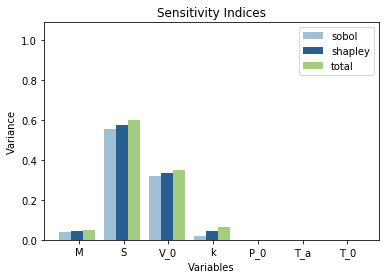

In [11]:
fig, ax = tr.sensitivity_analysis.plot_indices(metrics)

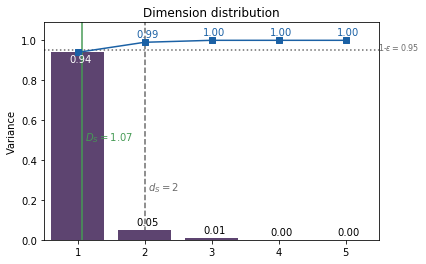

In [12]:
fig, ax = tr.sensitivity_analysis.plot_dim_distribution(metrics, max_order=5)

## Sobol __G__ function

Let's try now a more challenging example using the __Sobol _G_ __ function, which is a well-known synthetic model that can be tune for generating low or high-order interactions depending on the vector of coefficients __a_i__. A much more detailed description of this function can be also found at the [Virtual Library of Simulation Experiments](https://www.sfu.ca/~ssurjano/gfunc.html).

In this case, we will run the example with the same function parameters used in [2]:
  - **dimensions**: 20
  - **a_i**: 0 _[for i in range(n)]_

Again, the first step is to get the function object and the axis definitions from models library:

In [13]:
# Set example parameters
dims = 20
acoeff = 0

# Get example function and axes definitions from 'ttrecipes.models'
f_sobolg, axes_sobolg = tr.models.get_sobol_g(dims, a=acoeff, name_tmpl='X_{:0>2}')
pprint.pprint(axes_sobolg)

[{'name': 'X_00'},
 {'name': 'X_01'},
 {'name': 'X_02'},
 {'name': 'X_03'},
 {'name': 'X_04'},
 {'name': 'X_05'},
 {'name': 'X_06'},
 {'name': 'X_07'},
 {'name': 'X_08'},
 {'name': 'X_09'},
 {'name': 'X_10'},
 {'name': 'X_11'},
 {'name': 'X_12'},
 {'name': 'X_13'},
 {'name': 'X_14'},
 {'name': 'X_15'},
 {'name': 'X_16'},
 {'name': 'X_17'},
 {'name': 'X_18'},
 {'name': 'X_19'}]


Once the function and axes have been defined for our specific case, we just need to pass them as parameters to the __tr.sensitivity_analysis.var_metrics()__  function to get all the sensitivity metrics:

In [14]:
# Compute sensitivity indices and print result tables
print("+ Computing tensor approximations of variance-based sensitivity metrics...")
metrics = tr.sensitivity_analysis.var_metrics(
    f_sobolg, axes_sobolg, default_bins=bins, verbose=verbose, eps=1e-10,
    cross_kwargs=dict(kickrank=2), max_order=max_order)

display(HTML(tr.sensitivity_analysis.tabulate_metrics(
    metrics, show_titles=False, output_mode='string', tablefmt='html')))

+ Computing tensor approximations of variance-based sensitivity metrics...

-> Building surrogate model
Cross-approximating a 20D function with target error 1e-10...
=multifuncrs= sweep 1{2}, max_dy: 1.005e+01, erank: 2.89828
=multifuncrs= sweep 2{1}, max_dy: 5.334e-16, erank: 2.89828
Function evaluations: 59400
The resulting tensor has ranks [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1] and 16800 elements

-> Computing sensitivity metrics
=multifuncrs= sweep 1{2}, max_dy: 1.222e-01, erank: 2.89828
=multifuncrs= sweep 2{1}, max_dy: 3.727e-16, erank: 2.89828

-> Exporting results


Variable,Sobol,Total,Shapley,Banzhaf-Coleman
X_00,0.001062,0.250722,0.050000,0.019847
X_01,0.001062,0.250722,0.050000,0.019847
X_02,0.001062,0.250722,0.050000,0.019847
X_03,0.001062,0.250722,0.050000,0.019847
X_04,0.001062,0.250722,0.050000,0.019847
X_05,0.001062,0.250722,0.050000,0.019847
X_06,0.001062,0.250722,0.050000,0.019847
X_07,0.001062,0.250722,0.050000,0.019847
X_08,0.001062,0.250722,0.050000,0.019847
X_09,0.001062,0.250722,0.050000,0.019847


## Simulated decay chain

The third example simulates a radioactive decay chain that concatenates Poisson processes (it is a linear Jackson network) for 11 chemical species. Each species (except the last one) can decay into the next species in the chain.

This model has 10 parameters, namely the decay rates $\lambda_n$ of the 10 first species. The result of simulation $f_T(\lambda_1, \dots, \lambda_{10})$ is the amount of stable material (last node in the chain) measured after a certain time span $T$. The function $f_T$ simulates the decay chain by discretizing the span $T$ into timesteps of one day. The $\lambda_n$ (decay rates) represent the fraction of each material that decays every day. They are independent and uniformly distributed in the interval $[0.00063281, 0.00756736]$, which corresponds to half-lives from 3 years down to 3 months. The simulated time span for this example is set to 2 years ($T = 2$) as in [2]:

In [15]:
# Set example parameters
span = 2
products = 10

f_decay, axes_decay = tr.models.get_decay_poisson(
    N=products, span=span, hl_range=(3.0 * (1 / 12.0), 3.0),
    time_step=1.0 / 365.0, name_tmpl='lambda_{:0>2}')
pprint.pprint(axes_decay)

print("+ Computing tensor approximations of variance-based sensitivity metrics...")
metrics = tr.sensitivity_analysis.var_metrics(
    f_decay, axes_decay, default_bins=bins, verbose=verbose, eps=1e-4,
    max_order=max_order)

display(HTML(tr.sensitivity_analysis.tabulate_metrics(
    metrics, show_titles=False, output_mode='string', tablefmt='html')))

[{'domain': (0.00063281081452581933, 0.0075673557761656296),
  'name': 'lambda_00'},
 {'domain': (0.00063281081452581933, 0.0075673557761656296),
  'name': 'lambda_01'},
 {'domain': (0.00063281081452581933, 0.0075673557761656296),
  'name': 'lambda_02'},
 {'domain': (0.00063281081452581933, 0.0075673557761656296),
  'name': 'lambda_03'},
 {'domain': (0.00063281081452581933, 0.0075673557761656296),
  'name': 'lambda_04'},
 {'domain': (0.00063281081452581933, 0.0075673557761656296),
  'name': 'lambda_05'},
 {'domain': (0.00063281081452581933, 0.0075673557761656296),
  'name': 'lambda_06'},
 {'domain': (0.00063281081452581933, 0.0075673557761656296),
  'name': 'lambda_07'},
 {'domain': (0.00063281081452581933, 0.0075673557761656296),
  'name': 'lambda_08'},
 {'domain': (0.00063281081452581933, 0.0075673557761656296),
  'name': 'lambda_09'}]
+ Computing tensor approximations of variance-based sensitivity metrics...

-> Building surrogate model
Cross-approximating a 10D function with target

Variable,Sobol,Total,Shapley,Banzhaf-Coleman
lambda_00,0.049342,0.172755,0.100000,0.094528
lambda_01,0.049342,0.172755,0.100000,0.094528
lambda_02,0.049342,0.172755,0.100000,0.094528
lambda_03,0.049342,0.172755,0.100000,0.094528
lambda_04,0.049342,0.172755,0.100000,0.094528
lambda_05,0.049342,0.172755,0.100000,0.094528
lambda_06,0.049342,0.172755,0.100000,0.094528
lambda_07,0.049342,0.172755,0.100000,0.094528
lambda_08,0.049342,0.172755,0.100000,0.094528
lambda_09,0.049342,0.172755,0.100000,0.094528


## Fire-spread model

In the last example we use a function to model the rate of fire spread in the Mediterranean shrublands according to 10 variables that are fed into Rothermel's equations from [3]. We use the updated equations for the model from [4] since the authors kindly provided us the code of their function.

[3] _A mathematical model for predicting fire spread in wildland fuels (Tech.
Report)._ R. C. Rothermel. U.S. Department of Agriculture, Intermountain Forest and Range Experiment Station, 1972.

[4] _Shapley effects for global sensitivity analysis: Theory
and computation._ E. Song, B. L. Nelson, and J. Staum. SIAM/ASA Journal on Uncertainty Quantification, 4 (2016)

In [16]:
f_fire, axes_fire = tr.models.get_fire_spread(wind_factor=6.9)
pprint.pprint(axes_fire)

print("+ Computing tensor approximations of variance-based sensitivity metrics...")
metrics = tr.sensitivity_analysis.var_metrics(
    f_fire, axes_fire, default_bins=bins, verbose=verbose, eps=1e-4,
    cross_kwargs=dict(kickrank=4), max_order=max_order)

display(HTML(tr.sensitivity_analysis.tabulate_metrics(
    metrics, show_titles=False, output_mode='string', tablefmt='html')))

[{'dist': <scipy.stats._distn_infrastructure.rv_frozen object at 0x112635dd8>,
  'name': 'delta'},
 {'dist': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1117835f8>,
  'domain': (5.0, None),
  'name': 'sigma'},
 {'dist': <scipy.stats._distn_infrastructure.rv_frozen object at 0x112325be0>,
  'name': 'h'},
 {'dist': <scipy.stats._distn_infrastructure.rv_frozen object at 0x112644f28>,
  'name': 'rho_p'},
 {'dist': <scipy.stats._distn_infrastructure.rv_frozen object at 0x112644dd8>,
  'domain': (0, None),
  'name': 'm_l'},
 {'dist': <scipy.stats._distn_infrastructure.rv_frozen object at 0x112644cc0>,
  'name': 'm_d'},
 {'dist': <scipy.stats._distn_infrastructure.rv_frozen object at 0x112644b38>,
  'domain': (0, None),
  'name': 'S_T'},
 {'dist': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1126449b0>,
  'name': 'U'},
 {'dist': <scipy.stats._distn_infrastructure.rv_frozen object at 0x112644748>,
  'domain': (0, None),
  'name': 'tan_phi'},
 {'dist': <scipy.stats._dis

Variable,Sobol,Total,Shapley,Banzhaf-Coleman
delta,0.105820,0.331181,0.202908,0.195135
sigma,0.047668,0.234435,0.124713,0.116569
h,0.001228,0.005178,0.002836,0.002654
rho_p,0.004502,0.023386,0.012117,0.011208
m_l,0.142435,0.346492,0.231215,0.224610
m_d,0.095085,0.259270,0.165391,0.159520
S_T,0.001068,0.004506,0.002468,0.002309
U,0.090165,0.353358,0.201610,0.191561
tan_phi,0.002077,0.006053,0.003829,0.003712
P,0.029207,0.085198,0.052913,0.050780


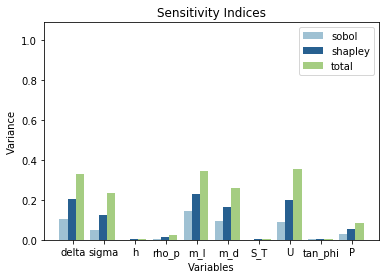

In [17]:
fig, ax = tr.sensitivity_analysis.plot_indices(metrics)

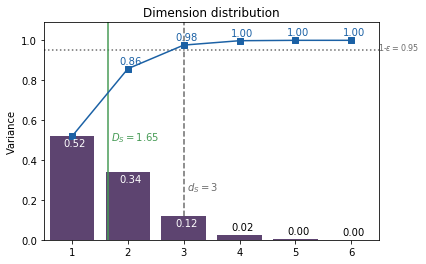

In [18]:
fig, ax = tr.sensitivity_analysis.plot_dim_distribution(metrics, max_order=6)